# Diffusion Models


Diffusion models represent a cutting-edge approach in machine learning, particularly in the domain of generative modeling and probabilistic inference. These models offer a novel perspective by treating data generation as a diffusion process rather than relying on traditional autoregressive or latent variable frameworks. In essence, diffusion models posit that a sequence of transformations is applied to an initial noise distribution, gradually morphing it into the observed data distribution. This approach allows for efficient sampling and likelihood estimation, circumventing challenges posed by complex dependencies in high-dimensional data. With their ability to capture intricate patterns and generate high-quality samples, diffusion models have garnered considerable attention across various applications, ranging from image and text generation to anomaly detection and data imputation. As research in diffusion models continues to evolve, they hold promise for pushing the boundaries of generative modeling and unlocking new avenues for understanding and synthesizing complex data distributions.

In this notebook, we're going to implement a diffusion model from scratch.



This implementation has three components as follows:
1. *scheduler* to inject noise into an image to use during training
2. *model* to predict the amount of noise in an image at any step for de-noising
3. *timestep encoder* to encode time for representation to the model


In [2]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
import numpy as np
import matplotlib.pyplot as plt
import math
import os


We'll use a dataset built in torch that has a collection of over 15,000 cars in 196 classes. We'll obtain the collection from Kaggle.
`data = torchvision.datasets.StanfordCars(root=".", download=True)`

In [36]:
data_path = "/kaggle/input/stanford-cars-dataset/cars_test/"


We'll display an image gallery with the first few images in the list. Proceed as follows:
1. Write function `show_images` with features of matplotlib
2. Load images from folder to dataset using Pytorch feature `ImageFolder`
3. Invoke the `show_images` function on dataset to display image gallery

The code is self-explanatory. Note the PyTorch feature `ImageFolder` to condition image data in a folder for presenting to a model. We will use this again shortly.

In [4]:
def show_images(dataset, num_samples=20, ncols=4):
    plt.figure(figsize=(15, 15))
    for i, (img, _) in enumerate(dataset):
        if i == num_samples:
            break
        img = img.permute(1, 2, 0)
        plt.subplot(num_samples // ncols, ncols, i + 1)
        plt.imshow(img)
        plt.axis('off')


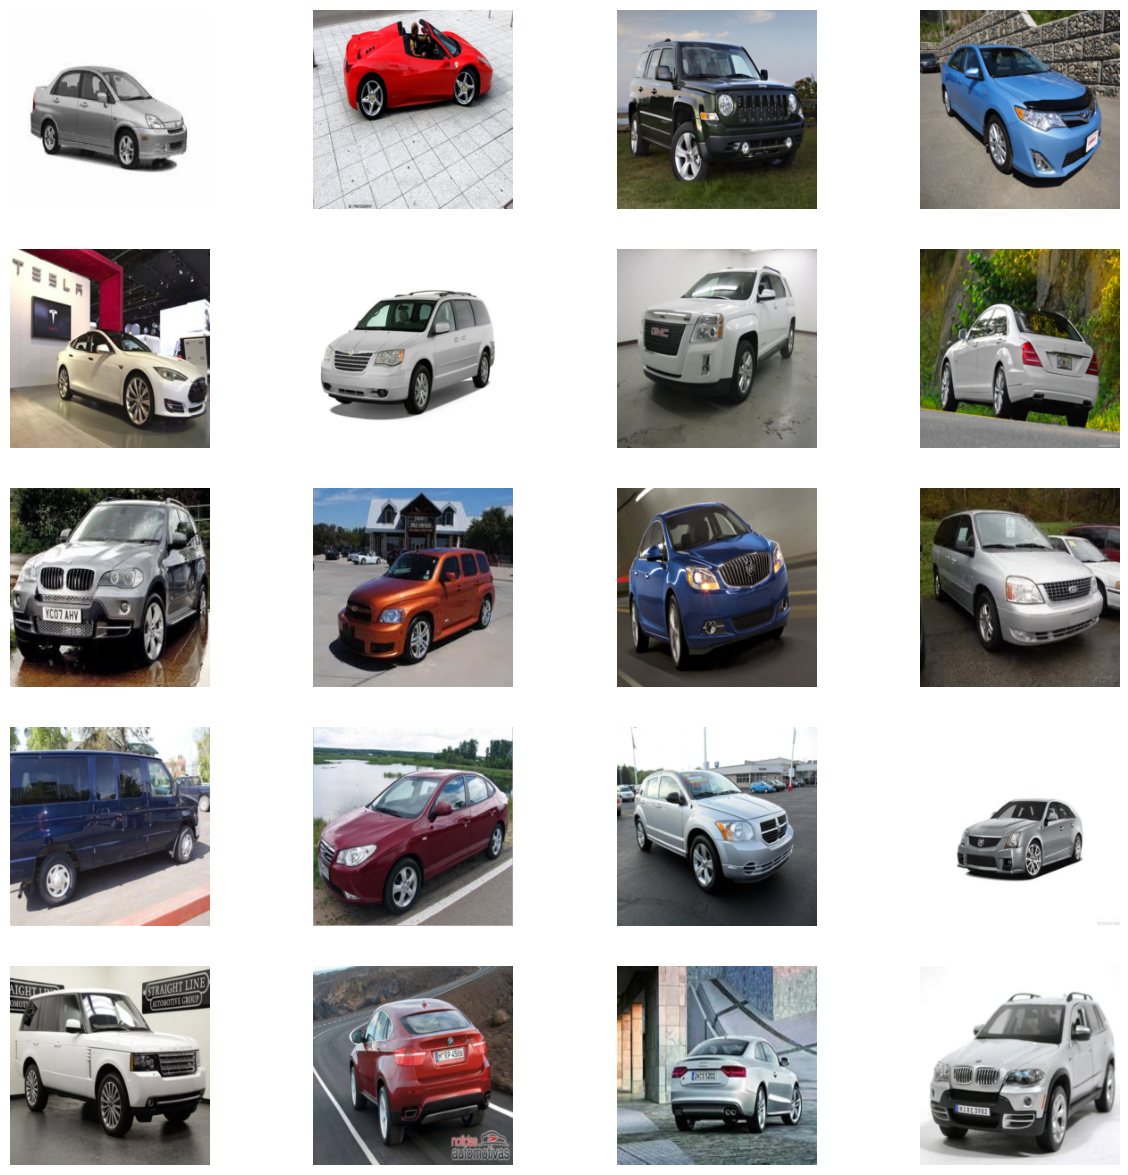

In [5]:
# Use torchvision's ImageFolder to load the images
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the images to a consistent size
    transforms.ToTensor()
])

data = ImageFolder(root=data_path, transform=data_transform)

show_images(data)

## 1. Scheduler

We create a scheduler to inject noise into images. To do so, we create a sequence of $\beta_{t}$s - a noise schedule, for how much noise is added to an image at each time step $t$. The goal is to add noise in steps so as to arrive at an isotropic Gaussian distribution (i.e. $\mu=0, \sigma=1$).

Due to a nice property of the Gaussian normal distribution, we can estimate the noisy image at any time step $t$ given the original $x_{0}$ without computing all the intermediate steps. How is this useful?

It is useful because we can sample a time step $t$ and calculate the noisy image without the need to iterate over the orginal image to get there.

Let's implement this in the next few steps:

### 1.1 Scheduler for diffusion

We need three helper functions and pre-calculated mathematics constants.  


In [6]:
def beta_linear_scheduler(timesteps, start=0.0001, stop=0.02):
    return torch.linspace(start, stop, timesteps)

def get_index_from_list(vals, t, x_shape):
    pass

def forward_diffusion_sample(x_0, t, device="cpu"):
    pass


There is a lot to unpack here, let's proceed to define the constants and circle back. Each constant is a 1D tensor of size `T` which is e.g. $300$. We will later sample each constant at a time point to obtain a coefficient to plug in the mathematical equations of Stable Diffusion.

In [7]:
# Step 1:
T = 300
betas = beta_linear_scheduler(T)
print("-- Shape of ---------------------------")
print("Betas\t:\t", betas.shape)
# Step 2:
alphas = 1.0 - betas
print("Alphas\t:\t", alphas.shape)
# Step 3:
alphas_cumprod = torch.cumprod(alphas, axis=0)
print("Alphas cumprod\t:\t", alphas_cumprod.shape)
# Step 4:
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
print("Alphas cumprod prev\t:\t", alphas_cumprod_prev.shape)
# Step 5:
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
print("Sqrt recip alphas\t:\t", sqrt_recip_alphas.shape)
# Step 6:
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
print("Sqrt alphas cumprod\t:\t", sqrt_alphas_cumprod.shape)
# Step 7:
sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alphas_cumprod)
print("Sqrt one minus alphas cumprod\t:\t", sqrt_one_minus_alphas_cumprod.shape)
# Step 8:
posterior_variance = betas * (1.0 - alphas_cumprod_prev) / (1.0 - alphas_cumprod)
print("Posterior variance\t:\t", posterior_variance.shape)
print("---------------------------------------")


-- Shape of ---------------------------
Betas	:	 torch.Size([300])
Alphas	:	 torch.Size([300])
Alphas cumprod	:	 torch.Size([300])
Alphas cumprod prev	:	 torch.Size([300])
Sqrt recip alphas	:	 torch.Size([300])
Sqrt alphas cumprod	:	 torch.Size([300])
Sqrt one minus alphas cumprod	:	 torch.Size([300])
Posterior variance	:	 torch.Size([300])
---------------------------------------


In [8]:
alphas_cumprod[:5], alphas_cumprod_prev[:5]
alphas_cumprod[-5:], alphas_cumprod_prev[-5:]
alphas[:5], sqrt_recip_alphas[:5]

(tensor([0.9999, 0.9998, 0.9998, 0.9997, 0.9996]),
 tensor([1.0000, 1.0001, 1.0001, 1.0001, 1.0002]))

*Step 1*

Create a linear sequence of betas from start to stop values.

*Step 2*

Subtract betas from 1.0 to obtain alphas. Remember the broadcasting rules.

*Step 3*

`torch.cumprod` returns the cumulative product of elements of input in the dimension dim.

For example, if input is a vector of size N, the result will also be a vector of size N, with elements.

$y_{i} = x_{1}\times x_{2}\times x_{3}\times ⋯\times x_{i}$


*Step 4*

This step has the effect of shifting `alphas_cumprod` one step to the right, dropping the last element and adding $1$ at start. Find details as follows:

The code `F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)` is using PyTorch's functional module (`F`) to pad a 1-dimensional tensor (`alphas_cumprod[:-1]`) along its first dimension. The padding is applied with a tuple `(1, 0)`, meaning 1 element is added to the beginning (left) of the tensor, and 0 elements are added to the end (right) of the tensor.

Additionally, the `value=1.0` argument specifies the constant value with which the tensor is padded. In this case, the padding elements are filled with the value `1.0`.

Here's a step-by-step breakdown:

- `alphas_cumprod[:-1]`: This slices the `alphas_cumprod` tensor, excluding the last element. It effectively takes all elements of the tensor except the last one.

- `F.pad(...)`: This applies padding to the sliced tensor.

- `(1, 0)`: This tuple specifies the number of elements to pad on each side of the tensor. In this case, it pads 1 element to the left and 0 elements to the right.

- `value=1.0`: This specifies the constant value (`1.0`) to use for filling the padded elements.

So, the overall effect of this code is to pad the `alphas_cumprod[:-1]` tensor with an additional element at the beginning, filling the padded element(s) with the value `1.0`. The resulting tensor will have a length that is one element greater than the original tensor.

*Step 5*

Take the square root of each element in the tensor - reciprocals of alphas.

*Step 6*

Take the square root of each element in the tensor - alphas cumulative product.

*Step 7*

Take the square root of each element in the tensor - one minus alphas cumulative product.

*Step 8*

Calculate covariance from Bayes' theorem.

Next, we will include the function definitions. We will make the steps explicit in a subsequent section with line-by-line explanations. For now, refer the docstrings for the high-level overview of each function.

In [9]:
def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timesteps)

def get_index_from_list(vals, t, x_shape):
    """
    Returns a specific index t of a passed list of values vals
    while considering the batch dimension.
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(x_0, t, device="cpu"):
    """
    Takes an image and a timestep as input and
    returns the noisy version of it
    """
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    # mean + variance
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
    + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)


# Define beta schedule
T = 300
betas = linear_beta_schedule(timesteps=T)

# Pre-calculate different terms for closed form
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

### 1.2 Create torch `DataLoader`

Let us load the images for presentation to PyTorch models using class `DataLoader`. As is typical, we will apply transformations to images to make them suitable for training models. We present images to models as tensors. So for plotting images using Pillow, we need to reverse the transforms. The function `load_transformed_dataset` has the transforms to resize images and convert to tensors and scale values. The function `show_tensor_image` then takes a batch of images from `DataLoader` instance and converts to images for viewing, applying the reverse of the transforms.

In [10]:
IMG_SIZE = 64
BATCH_SIZE = 128

def load_transformed_dataset():
    data_transforms = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),  # Scales data in range [0, 1]
        transforms.Lambda(lambda t: (t * 2) - 1)  # Scales data in range [-1, 1]

    ])

    path_train = "/kaggle/input/stanford-cars-dataset/cars_train/"
    path_test = "/kaggle/input/stanford-cars-dataset/cars_test/"
    train = ImageFolder(root=path_train, transform=data_transforms)
    test = ImageFolder(root=path_test, transform=data_transforms)

    return torch.utils.data.ConcatDataset([train, test])

def show_tensor_image(image, v=True):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)),  # From CHW to HWC
        transforms.Lambda(lambda t: t * 255.0),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    print("Before: ", image.shape) if v else None
    if len(image.shape) == 4:    # Batch x 3 Channels
        image = image[0]         # Take 1st of batch
        image = image.squeeze()
    print("After: ", image.shape) if v else None
    plt.imshow(reverse_transforms(image))
    plt.axis('off')

In [11]:
dd = load_transformed_dataset()

In [12]:
dl = DataLoader(dd, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

Find the explanation of the args. of `DataLoader` below. In particular,

*shuffle* will reshuffle the data at every epoch

*drop_last* will drop the last incomplete batch if the size of the dataset is not divisible by the batch size.

Use `dl??` for more.

In [13]:
#dl??

In [14]:
# Number of batchs in `DataLoaders`
len(dl)

126

In [15]:
# Contents of a batch
# One batch has 128 images in 3 channels with 64x64 px ea.
next(iter(dl))[0].shape

torch.Size([128, 3, 64, 64])

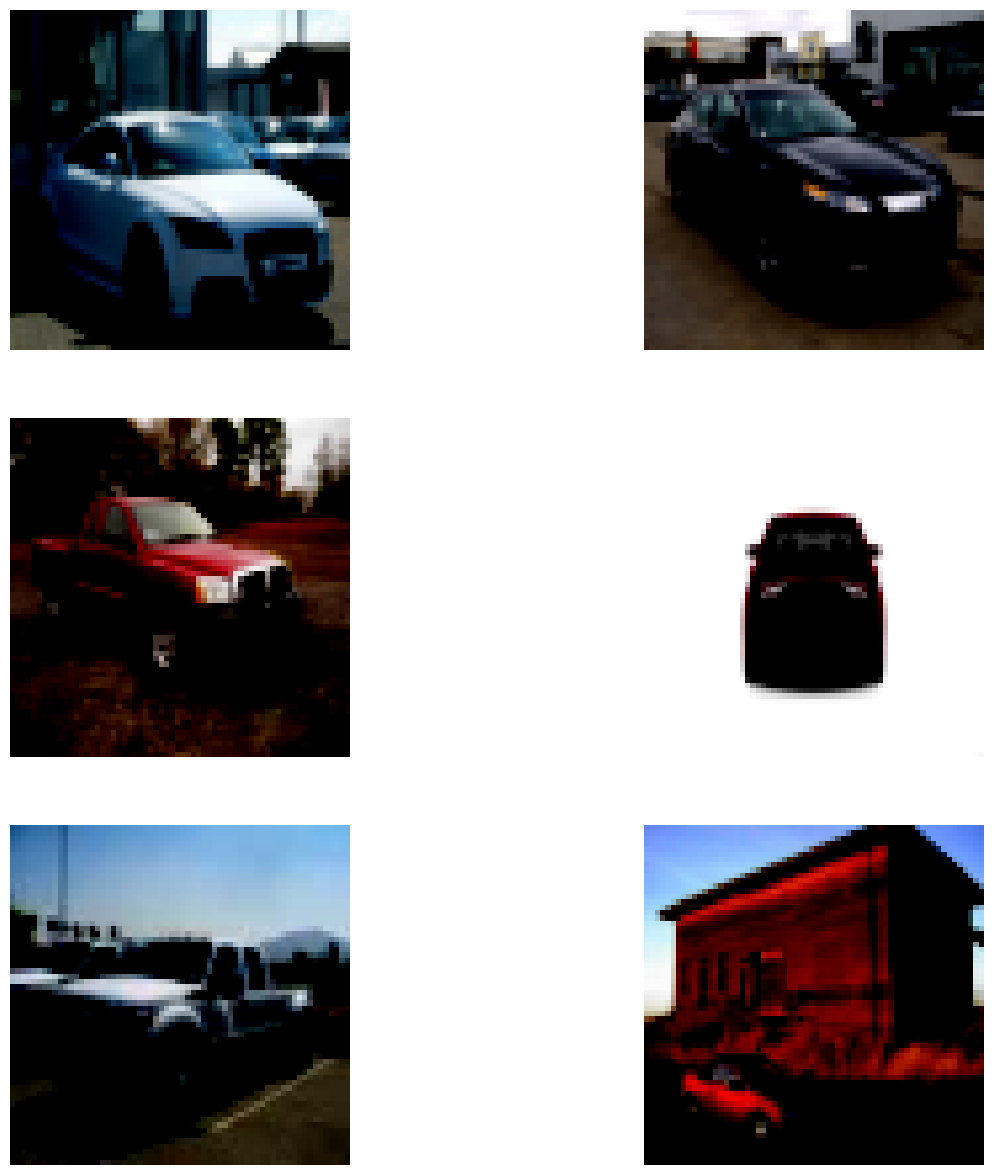

In [16]:
show_images(dd, 6, 2)

### 1.3 Forward diffusion on single image

We will explicitly show the tensor operations encapsulated in the functions `get_index_from_list` and `forward_diffusion_sample` defined above so we can elucidate each step. Having done this, we will use the functions to obtain the same result.

In [17]:
im_batch = next(iter(dl))[0]
im_batch.shape

torch.Size([128, 3, 64, 64])

0 : 1 tensor([0.9999]) (1, 1, 1, 1) tensor([[[[0.9999]]]]) tensor([[[[0.0100]]]])
torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])
tensor([0.9999]) tensor([0.9999])
Before:  torch.Size([128, 3, 64, 64])
After:  torch.Size([3, 64, 64])
30 : 1 tensor([0.9831]) (1, 1, 1, 1) tensor([[[[0.9831]]]]) tensor([[[[0.1830]]]])
torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])
tensor([0.9831]) tensor([0.9831])
Before:  torch.Size([128, 3, 64, 64])
After:  torch.Size([3, 64, 64])
60 : 1 tensor([0.9380]) (1, 1, 1, 1) tensor([[[[0.9380]]]]) tensor([[[[0.3467]]]])
torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])
tensor([0.9380]) tensor([0.9380])
Before:  torch.Size([128, 3, 64, 64])
After:  torch.Size([3, 64, 64])
90 : 1 tensor([0.8684]) (1, 1, 1, 1) tensor([[[[0.8684]]]]) tensor([[[[0.4959]]]])
torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])
tensor([0.8684]) tensor([0.8684])
Before:  torch.Size([128, 3, 64, 64])
After:  torch.Size([3, 64, 64])
120 : 1 tensor([0.780

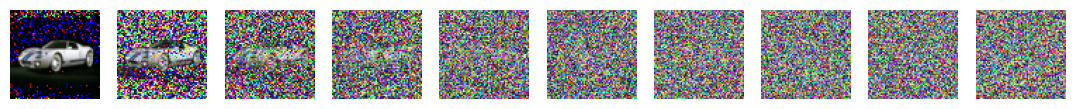

In [18]:
plt.figure(figsize=(15, 15))
number_images = 10
stepsize = T // number_images

for idx in range(0, T, stepsize):
    t = torch.tensor([idx]).type(torch.int64)
    # forward_diffusion_sample(image, t)
    # # Sample time t
    size_t = t.shape[0]   #
    sqrt_alphas_cumprod_t = sqrt_alphas_cumprod.gather(-1, t.cpu())
    out_size = (size_t, *((1,) * (len(im_batch.shape) - 1)))
    out = sqrt_alphas_cumprod_t.reshape(out_size)
    sqrt_one_minus_alphas_cumprod_t = sqrt_one_minus_alphas_cumprod.gather(-1, t.cpu())
    out_ = sqrt_one_minus_alphas_cumprod_t.reshape(out_size)
    print(t[0].item(), ":", size_t, sqrt_alphas_cumprod_t, out_size, out, out_)  # Batch size

    # # Add noise
    noize = torch.randn_like(im_batch)
    im_batch_ = sqrt_alphas_cumprod_t * im_batch + sqrt_one_minus_alphas_cumprod_t * noize
    print(noize.shape, im_batch_.shape)

    # # Compare gather with direct indexing
    print(sqrt_alphas_cumprod[t], sqrt_alphas_cumprod.gather(-1, t.cpu()))

    # # Plot
    plt.subplot(1, number_images + 1, idx // stepsize + 1)
    show_tensor_image(im_batch_)

print("\nshapes")
print("t", t.shape)
print("sqrt_alphas_cumprod", sqrt_alphas_cumprod.shape)
print("im_batch", im_batch.shape)
print("out", out.shape)
print("out_", out_.shape)
print("noize", noize.shape)

What's happening in each iteration of the loop is as follows:

1. `t = torch.tensor([idx]).type(torch.int64)` Convert the index (int) into a 1D tensor of 1 element. This represents the time point at which we will sample a noisy image.
2. `size_t = t.shape[0]` This is the size of contents `t` which is 1D tensor of 1 element. This is simply $1$.
3. `sqrt_alphas_cumprod_t = sqrt_alphas_cumprod.gather(-1, t.cpu())` This is the equivalent of `sqrt_alphas_cumprod[t]` and also results in a 1D tensor with one element, sampling the list of alphas cumulative product at the time point `t`. Direct slicing generates a view that uses the same underlying tensor representation. The `gather` operation used here creates a new tensor by gathering values from the original tensor based on indices provided by the index tensor. It is capable of far more complex sampling that what is shown/needed here. Refer to [gather in layman's terms](https://stackoverflow.com/questions/50999977/what-does-the-gather-function-do-in-pytorch-in-layman-terms). `gather(-1, t.cpu())` introduces an additional step of moving the index tensor to the CPU. e.g. output is tensor([0.9831]).
4. `(size_t, *((1,) * (len(im_batch.shape) - 1)))` Used to reshape the sampled list of alphas cumulative product at the time point to match the batching requirements. Say our batch is 128x3x64x64. Our sampled list of alphas cumulative product is a 1D tensor of 1 element. Together, these produce the result `[1,1,1,1]`, with the first $1$ from $t$ followed by three $1$s for one image from a batch of images.
5. `sqrt_alphas_cumprod_t.reshape(size_t)` The reshape operation that takes a sampled alphas cumulative product at one time point in the schedule and matches the batching requirement. E.g. tensor([0.9831]) will become tensor([[[[0.9831]]]]).    
6. `sqrt_one_minus_alphas_cumprod.gather(-1, t.cpu())` Sample as before.
7. `sqrt_one_minus_alphas_cumprod_t.reshape(out_size_t)` Reshape as before.
8. `torch.randn_like(im_batch)` Make a noisy image with isotropic Gaussian normal noise.
9. `sqrt_alphas_cumprod_t * im_batch + sqrt_one_minus_alphas_cumprod_t * noize
    print(noize.shape, im_batch_.shape)` Adjust the level of noise and add to the image. Here is where matching the sampled lists at the time point to the batching requirement will result in broadcasting correctly. We will return this result along with the pure noise.
    
Now, let us implement the same process of adding noise with the functions we have defined for the purpose. This is much fewer lines of code!

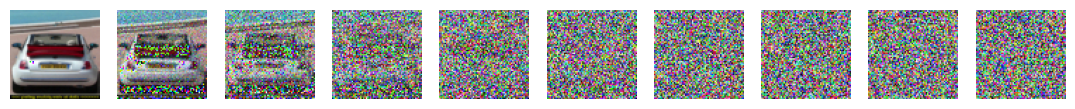

In [19]:
im_batch = next(iter(dl))[0]

plt.figure(figsize=(15, 15))
number_images = 10
stepsize = T // number_images

for idx in range(0, T, stepsize):
    t = torch.tensor([idx]).type(torch.int64)
    plt.subplot(1, number_images + 1, idx // stepsize + 1)
    img, noise = forward_diffusion_sample(im_batch, t)
    show_tensor_image(img, v=False)


## 2. U-Net building blocks

We will define the blocks for UNet. We will use almost every class of Pytorch `nn` to build out the architecture. The classes we implement for each substructural component shall inherit from `nn.Module`, contain the layers as attributes, and implement the `forward` method for defining the connections between layers. The three classes are as follows:
1. `Block` - These are the core building blocks of the UNet and each instance has multiple (3) convolutional layers (filter banks). The net effect of a block on the downsampling path is increasing channels and reducing image size. The net effect of a block on the upsampling path is decreasing channels and increasing image size.
2. `SimpleUnet` - This is the highest-level container that puts the buildling blocks together. It arranges instances of `Block` such that we have a downsampling path where the image size decreases and number of channels increases in successive steps, followed by an upsampling path where the image size increases and the number of channels decreases in successive steps. Thus, the input and output tensors are the same size. The goal of the UNet is to predict the noise in an image.
3. `SinusoidalPositionEmbeddings` - The mathematical development of Stable Diffusion requires embedding temporal information along with the spatial information in an image. Different amounts of noise are injected according to the noising schedule depending on the time point sampled. Therefore, the temporal information needs to be convyed to the UNet for training. How to do go about it? The authors recommend representing temporal information using sinusoidal embedding - originally a method of of generating embeddings to represent discrete positional information in the context of Transformer models. The temporal embeddings are fixed for a given time point and added to the image so the tensor sizes remain unchanged and both temporal and spatial information are conveyed.  

This is a lot of information. Let us unpack for implementation.

### 2.1 `Block` for building  U-Net

To start with, we would have the class implementation as follows:

```
class Block(nn.Module):
    self.__init__(self, in_ch, out_ch, up=False):
        super.__init__()
        self.conv0 = nn.Conv2d()
        if up:
            self.conv1 = nn.Conv2d(2*channels_in, channels_out, 3, padding=1)
            self.transform = nn.ConvTranspose2D(channels_out, channels_out, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(channels_in, channels_out, 3, padding=1)
            self.transform = nn.Conv2d(channels_out, channels_out, 4, 2, 1)
        self.conv2 = nn.conv2d(channels_out, channels_out, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(channels_out)
        self.bnorm2 = nn.BatchNorm2d(channels_out)
        self.relu = nn.ReLU()
    
    self.forward(self, x, t):
        h = self.bnorm1(self.relu(self.conv1(x)))
        h = self.bnorm2(self.relu(self.conv2(h)))
        return h
    
```

We have applied a series of transforms as follows:
- bnorm1 <- relu <- conv1
- bnorm2 <- relu <- conv2
- transform
        
1. Downsampling, the block output tensor has half the image size and double the channels. Upsampling, the block output tensor has double the image size and half the channels. Thus, pattern in number of channels could be 64, 128, 256, 512, 1024, 512, 256, 128, 64 with transition at 1024.
2. On both the down/up sampling paths, the output of one block is the input to the next block in the sequence. However, the UNet architecture's residual connections lead to a doubling of the inputs for a block on the upsampling path. Each of these blocks has two same-sized tensors as input - an input from the regular connection with the block before it on the same path, and another from the residual connection with the mirror image on the downsampling path. Therefore, conv1 of the upsampling path has double the number of input channels as its mirroring block on the downsampling path to accomodate the residual connections.
3. The augmentation/reduction of channels occurs in the 1st transform in a block and the augmentation/reduction of image occurs in the last.

This implementation so far leaves out the temporal encoding. We'll describe that next.


In [20]:
class Block(nn.Module):
    def __init__(self, channels_in, channels_out, time_emb_size, up=False, v=False):
        '''
        Apply a series of transforms as follows:
            bnorm1 <- relu <- conv1
            bnorm2 <- relu <- conv2
            transform
        1.
        Downsampling, the block output tensor has half the image size
        and double the channels. Upsampling, the block output tensor
        has double the image size and half the channels. Thus, pattern
        in number of channels could be 64, 128, 256, 512, 1024, 512,
        256, 128, 64 with transition at 1024.
        2.
        On both the down/up sampling paths, the output of one block
        is the input to the next block in the sequence. However,
        the UNet architecture's residual connections lead to a doubling
        of the inputs for a block on the upsampling path. Each of these
        blocks has two same-sized tensors as input - an input from the
        regular connection with the block before it on the same path,
        and another from the residual connection with the mirror image
        on the downsampling path. Therefore, conv1 of the upsampling path
        has double the number of input channels as its mirroring block
        on the downsampling path to accomodate the residual connections.
        3.
        The augmentation/reduction of channels occurs in the 1st transform
        in a block and the augmentation/reduction of image occurs in the last.

        '''
        super().__init__()
        self.verbose = v
        self.time_mlp = nn.Linear(time_emb_size, channels_out)
        if up:
            self.conv1 = nn.Conv2d(2*channels_in, channels_out, 3, padding=1)
            self.transform = nn.ConvTranspose2d(channels_out, channels_out, kernel_size=4, stride=2, padding=1)
        else:
            self.conv1 = nn.Conv2d(channels_in, channels_out, 3, padding=1)
            self.transform = nn.Conv2d(channels_out, channels_out, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(channels_out, channels_out, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(channels_out)
        self.bnorm2 = nn.BatchNorm2d(channels_out)
        self.relu = nn.ReLU()

    def forward(self, x, t_emb):
        print("--- Block shapes ------------------------------") if self.verbose else None
        # 1st convolution with ReLU non-linearity and batch normalization
        h = self.bnorm1(self.relu(self.conv1(x)))
        print("1st conv", h.shape) if self.verbose else None
        # Internal representation of temporal information
        # with reshaping for compatibility with image
        # before addition to image
        t_out = self.relu(self.time_mlp(t_emb))
        t_out = t_out[..., None, None] # Same difference! # t_out[(..., ) + (None, )*2]
        print("t_out shape", t_out.shape) if self.verbose else None
        h = h + t_out
        # 2nd convolution with ReLU non-linerarity and batch normalization
        h = self.bnorm2(self.relu(self.conv2(h)))
        print("conv2 shape", h.shape) if self.verbose else None
        # Final layer and retval
        return self.transform(h)

The complete implementation has a few additional features as follows:

1. Temporal information is in each block.
2. The temporal information is encoded before it is conveyed to a block -`t_emb`. In the UNet, a time point undergoes sinusoidal embedding to inflate to `time_emb_size`, followed by processing in a fully connected layer with `time_emb_size` neurons and ReLU non-linearity, This gives the UNet a chance to develop an internal representation for temporal embedding. This representation then gets further processed in a fully-connected layer in each block, with `channels_out` neuros and ReLU non-linerarity, giving each block further opportunity to tweak the representation internally and to align the size of the embedding to match the image.
3. Resizing..

The  orchestration falls to the`SimpleUnet` block. Before we jump to that, let us look at the implementation of `SinusoidalPositionEmbeddings`.

### 2.2 `SinusoidalPositionEmbeddings` for positional encoding temporal information

The U-Net processes images - image in, image out. Every block of the U-Net on downsampling path and upsampling path has image in, image out - what changes is the number of channels and the size of image. The math of stable diffusion requires that we convey time information along with the image. How to do that?

We embed the time information in the image itself. Proceed as follows:
1. Embed the discrete time point (scalar) into the space (vector) of latent factors.
2. Reshape the vector of latent factors to align with image size.
3. Add the temporal information in 2. to the image.

Note that all calculations in 1. to 3. involve tensors. The 1st step uses a popular approach that derives from transformer models - sinusoidal position embedding.  

In [21]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, emb_size):
        super().__init__()
        self.emb_size = emb_size

    def forward(self, t):
        device = t.device
        emb_half_size = self.emb_size // 2
        embeddings = math.log(10000) / (emb_half_size - 1)
        embeddings = torch.exp(torch.arange(emb_half_size, device=device) * -embeddings)
        embeddings = t[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)

        return embeddings

In [22]:
spe = SinusoidalPositionEmbeddings(32)
spe(torch.tensor([30]))

tensor([[-0.9880, -0.5030,  0.5963, -0.9991,  0.5384,  0.9841,  0.6842,  0.3966,
          0.2189,  0.1191,  0.0646,  0.0350,  0.0189,  0.0102,  0.0055,  0.0030,
          0.1543, -0.8643, -0.8028,  0.0423, -0.8427,  0.1774,  0.7293,  0.9180,
          0.9757,  0.9929,  0.9979,  0.9994,  0.9998,  0.9999,  1.0000,  1.0000]])

The scaling factor `math.log(10000) / (emb_half_size - 1)` is used to control the frequency and scale of the sinusoidal embeddings. The logarithm term introduces a logarithmic scaling, and the division by (emb_half_size - 1) adjusts the frequency based on the size of the embeddings. This kind of scaling is often used to ensure that the sinusoidal embeddings cover a reasonable range of frequencies and amplitudes, making them suitable for representing positions in sequences of varying lengths. Adjusting these parameters allows practitioners to fine-tune the embeddings to the specific requirements of their models and tasks.

### 2.3 U-Net

Now we have all the building blocks we need to construct our U-Net. Let's proceed!


In [23]:
class SimpleUnet(nn.Module):
    def __init__(self, v=False):
        '''
        channels_im (int) is the #channels of the U-Net's image at input and output
        channels_dn (list[int]) is the #channels in the sequence on downsampling path
        channels_up (list[int]) is the #channels in the sequence on upsampling path
        time_emb_size (int) is the size of the embedding of a discrete time point

        The architecture is layered as follows:
        time_mlp (nn.Sequential) is a fully-connected layer that processes time embeddings
        conv0 (nn.Conv2d) is a convolutional layer - 3 ch. to 64 ch. image same size
        downs (nn.ModuleList([Block])) is a set of blocks on the downsampling path
        ups (nn.ModuleList([Block])) is a set of blocks on the upsampling path
        output (nn.Conv2d) is a
        '''
        super().__init__()
        self.verbose = v
        self.channels_im = 3
        self.channels_dn = (64, 128, 256, 512, 1024)
        self.channels_up = (1024, 512, 256, 128, 64)
        self.time_emb_size = 32

        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(self.time_emb_size),
            nn.Linear(self.time_emb_size, self.time_emb_size),
            nn.ReLU()
        )

        self.conv0 = nn.Conv2d(self.channels_im, self.channels_dn[0], 3, padding=1)

        self.downs = nn.ModuleList(
            [Block(self.channels_dn[i], self.channels_dn[i+1], \
                    self.time_emb_size, up=False, v=self.verbose) \
             for i in range(len(self.channels_dn)-1)
            ]
        )

        self.ups = nn.ModuleList(
            [Block(self.channels_up[i], self.channels_up[i+1], \
                    self.time_emb_size, up=True, v=self.verbose) \
            for i in range(len(self.channels_up)-1)]
        )

        self.output = nn.Conv2d(self.channels_up[-1], self.channels_im, 1)

    def forward(self, x, t):
        '''
        t (tensor 1D) embedding of discrete time
        x (tensor 3D) image in varying #channels according to stage
        residual_inputs (List[Tensor 3D]) List of outputs on downsampling path
          to use as concatenated input on upsampling path - Last In, First Out
        '''
        print("--- U-Net shapes ------------------------------") if self.verbose else None
        print("t", t) if self.verbose else None
        t_emb = self.time_mlp(t)
        print("t_emb", t_emb.shape) if self.verbose else None
        x = self.conv0(x)
        print("x", x.shape) if self.verbose else None
        residual_inputs = []
        for down in self.downs:
            x = down(x, t_emb)
            print("x dn", x.shape) if self.verbose else None
            residual_inputs.append(x)
            print("residuals", len(residual_inputs)) if self.verbose else None
        for up in self.ups:
            x = torch.cat((x, residual_inputs.pop()), dim=1)
            x = up(x, t_emb)
            print("x up", x.shape) if self.verbose else None
        return self.output(x)

    def set_silent(self):
        '''
        Turn off verbosity for U-Net and constituent Blocks.
        '''
        self.verbose = False
        for down in self.downs:
            down.verbose = False
        for up in self.ups:
            up.verbose = False


Moment of truth!

In [24]:
model = SimpleUnet(v=True)
print("Number of parameters is ", sum(p.numel() for p in model.parameters()))
model

Number of parameters is  62438883


SimpleUnet(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): Block(
      (time_mlp): Linear(in_features=32, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): Block(
      (time_mlp): Linear(in_features=32, out_features=256, bias=True)
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transfor

### 2.4 A note on `nn` classes

**Common Ancestor** `
- `nn.Module`

**Containers**
- `nn.ModuleList` - needs explicit `forward` to define connections
- `nn.Sequential` - implict `forward`

**Individual Layers**
- `nn.Linear` - #in, #out
- `nn.Conv2d` - #channels in, #channels out, kernel size, stride, padding
- `nn.ConvTranspose2d`

**Post-processing**
- `nn.BatchNorm2d` - #channels
- `nn.ReLU`


In constructing the U-Net,

### 2.5 A note on tensor manipulation

Throughout this notebook we have seen multiple instances of tensor manipulation, such as:1
1. Sampling a tensor systematically in flexible ways to create a new tensor with `gather`.
2. Modiying dimensions with `reshape` or padding with `...` (`Ellipsis`) and `None` dimensions.
3. Broadcasting to operate on tensors of unequal sizes.

[SO Ellipsis](https://stackoverflow.com/questions/62442198/tensor-index-manipulation-with)
[SO gather](https://stackoverflow.com/questions/50999977/what-does-the-gather-function-do-in-pytorch-in-layman-terms)
[Torch docs - Broadcasting](https://pytorch.org/docs/stable/notes/broadcasting.html)

In [25]:
import torch

print("Before:")
# Create a tensor with shape (3, 4, 5) as an example
time_emb = torch.randn(3, 4, 5)
# Try me1 # time_emb = torch.tensor([9])
print("time_emb", time_emb if time_emb.numel() == 1 else time_emb.shape)

print("After:")
# Add two singleton dimensions using the first approach
expanded_time_emb_1 = time_emb[(..., ) + (None, ) * 2]
print("time_emb_expanded_1", expanded_time_emb_1 if expanded_time_emb_1.numel() == 1 else expanded_time_emb_1.shape)

# Add two singleton dimensions using the second approach
expanded_time_emb_2 = time_emb[..., None, None]
print("time_emb_expanded_2", expanded_time_emb_2 if expanded_time_emb_2.numel() == 1 else expanded_time_emb_2.shape)

expanded_time_emb_reshape = time_emb.reshape(*time_emb.shape, 1, 1)
print("expanded_time_emb_reshape", expanded_time_emb_reshape if expanded_time_emb_reshape.numel() == 1 else expanded_time_emb_reshape.shape)

# Check if the shapes are the same
print("Shape using first approach:", expanded_time_emb_1.shape)
print("Shape using second approach:", expanded_time_emb_2.shape)
print("Shape using reshape approach:", expanded_time_emb_reshape.shape)

# Check if the tensors are equal (element-wise)
print("Tensors are equal:", torch.equal(expanded_time_emb_1, expanded_time_emb_2))
print("Tensors are equal:", torch.equal(expanded_time_emb_1, expanded_time_emb_reshape))

Before:
time_emb torch.Size([3, 4, 5])
After:
time_emb_expanded_1 torch.Size([3, 4, 5, 1, 1])
time_emb_expanded_2 torch.Size([3, 4, 5, 1, 1])
expanded_time_emb_reshape torch.Size([3, 4, 5, 1, 1])
Shape using first approach: torch.Size([3, 4, 5, 1, 1])
Shape using second approach: torch.Size([3, 4, 5, 1, 1])
Shape using reshape approach: torch.Size([3, 4, 5, 1, 1])
Tensors are equal: True
Tensors are equal: True


## 3. Loss and Training

We will write the following functions for training:
1. Loss function
2. Denoising based on U-Net output
3. Training U-Net to predict noise

During the training, at some frequence (e.g. 10 epochs), we will use the model to predict noise and attempt to create images of cars.

### 3.1 Loss Function

The goal of the U-Net is to predict noise in an image. The prediction becomes the input to denoising process. The U-Net requires a loss function for training. Since we know the noise we have added to each pixel in the noising process, we can compare that noise and the predicted noise to calculate the loss on the basis of the difference. As is typical, the loss function then gives rise to gradients for training the U-Net to make more accurate predictions of noise.

You can see why we chose the U-Net model. The architecture lends itself to working with images to predict an output that conforms to the shape of the input image. The output usually represents some difference over the input image, such as a segmentation mask in medical image analysis. In our use-case, it is the noise in images of cars.

In [26]:
def get_loss(model, x_0, t):
    '''
    Args:
    model (nn.Module) is U-Net with over 62M parameters
    x_0 (tensor 4D) is a batch of images
    t (tensor 1D) is a time point as 1D tensor or 1 element
    Returns:
    The loss (scalar) computed from the actual and predicted noise
    '''
    x_noisy, noize = forward_diffusion_sample(x_0, t, device)
    noize_pred = model(x_noisy, t)
    return F.l1_loss(noize, noize_pred)

### 3.2 Denoising

Here are some of the individual operations involved in denoising. We'll wrap these in a function that uses the model's predicted output to generate an image. As per the mathematical development of stable diffusion, we will need to step backwards through time in steps to recover the image from predicted noise.

We will write a function `sample_timestep(img_t, t)` for the de-noising recipe at any single timestep. This will take an image $img_t$ from the time point $t$ and return the image at time point $t-1$. For this, it will subtract noise predicted by the U-Net - `model(img_t, t)`.

Then we will write a wrapper function `sample_plot_image` to iterate over time points from $T$ to $0$ in reverse manner as forward diffusion and call `sample_timestamp` at each step. The de-noised image from one step is the input to the next and U-Net is invoked each time to predict the noise at that time point.

Thus, little by little, the noise clears up to reveal an image of a car. (Or does it?)

The sampling of tensors at a given time point, using the `gather` and `reshape` operations of `get_index_from_list` is illustrated below. Also note that the `forward` method of class inheriting from `nn.Module` is invoked implicitly when the instance is called as if it were a function with the expected args. - e,g, `model(x, t)`.  

In [27]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
img = torch.randn((1, 3, IMG_SIZE, IMG_SIZE)).to(device)
print(img.shape)
t = torch.tensor([0]).to(device)
print("-- Sample at time-step t = ", t, "-----------")
print("betas: ", get_index_from_list(betas, t, img.shape))
print("sqrt_one_minus_alphas_cumprod", get_index_from_list(sqrt_one_minus_alphas_cumprod, t, img.shape))
print("sqrt_recip_alphas", get_index_from_list(sqrt_recip_alphas, t, img.shape))
print("posterior variance", get_index_from_list(posterior_variance, t, img.shape))
print("------------------------------------[ END ] -------")
model.to(device)
model(img, t)

cuda
torch.Size([1, 3, 64, 64])
-- Sample at time-step t =  tensor([0], device='cuda:0') -----------
betas:  tensor([[[[1.0000e-04]]]], device='cuda:0')
sqrt_one_minus_alphas_cumprod tensor([[[[0.0100]]]], device='cuda:0')
sqrt_recip_alphas tensor([[[[1.0000]]]], device='cuda:0')
posterior variance tensor([[[[0.]]]], device='cuda:0')
------------------------------------[ END ] -------
--- U-Net shapes ------------------------------
t tensor([0], device='cuda:0')
t_emb torch.Size([1, 32])
x torch.Size([1, 64, 64, 64])
--- Block shapes ------------------------------
1st conv torch.Size([1, 128, 64, 64])
t_out shape torch.Size([1, 128, 1, 1])
conv2 shape torch.Size([1, 128, 64, 64])
x dn torch.Size([1, 128, 32, 32])
residuals 1
--- Block shapes ------------------------------
1st conv torch.Size([1, 256, 32, 32])
t_out shape torch.Size([1, 256, 1, 1])
conv2 shape torch.Size([1, 256, 32, 32])
x dn torch.Size([1, 256, 16, 16])
residuals 2
--- Block shapes ------------------------------
1st c

tensor([[[[-7.7206e-02, -1.4232e-01, -1.8544e-01,  ..., -2.3255e-02,
           -8.2066e-02, -9.6170e-02],
          [-1.6257e-01,  1.8739e-02, -1.3884e-01,  ..., -1.7749e-01,
            8.2335e-02, -1.7964e-01],
          [ 7.6422e-04, -1.4832e-01, -8.3810e-02,  ..., -1.3243e-01,
           -1.5839e-01, -1.1770e-01],
          ...,
          [ 7.0443e-02,  2.9421e-02,  4.2178e-03,  ...,  6.5006e-02,
            5.6285e-02, -1.8423e-01],
          [-1.9984e-02, -2.2292e-01, -5.3206e-02,  ...,  2.2967e-01,
           -9.4919e-03, -1.8124e-01],
          [-1.2347e-01, -5.4088e-02, -2.9562e-02,  ..., -1.1218e-01,
           -3.5378e-02, -1.7589e-01]],

         [[-5.6838e-02, -1.6018e-02,  1.7050e-02,  ..., -7.8363e-03,
           -1.0886e-04, -6.6274e-02],
          [-1.6719e-02, -1.2080e-01, -3.9595e-02,  ...,  6.0074e-02,
           -4.4797e-02,  4.9593e-03],
          [-1.4481e-01, -6.6188e-02, -7.9699e-02,  ...,  1.8974e-01,
            1.9975e-01, -3.3793e-02],
          ...,
     

Let's write the function `sample_timestep` to take an image at a given time point, predict the noise with U-Net, perform one step of de-noising. Note that the starting point (in `sample_plot_image` is an image of the the correct shape i.e 1x3x64x64 and pure Gaussian noise!

In simple terms, what we want to do is as follows:

$img_{t-1} = img_{t} - \hat{noise}$

The mathematical formula per the published [recipe](https://theaisummer.com/diffusion-models/) is as follows:

${\textbf{x}_{t-1}} = \frac{1}{\sqrt{\alpha_{t}}}\left({\textbf{x}_{t}}-\frac{\beta_{t}}{\sqrt{1-\overline{\alpha_{t}}}}\boldsymbol{\epsilon}\right)$

Here, the notation signifies the following:
- $\textbf{x}_{t-1}$, $\textbf{x}_{t}$ and $\boldsymbol{\epsilon}$ are images of the same size
- $\textbf{x}_{t-1}$ is calculated by subtracting noise $\boldsymbol{\epsilon}$ from $\textbf{x}_{t}$
- Noise $\boldsymbol{\epsilon}$ is U-Net's prediction, given $\textbf{x}_{t}$ and $t$

Stable Diffusion hinges on the face that we can predict the noise in a noisy image at a given time point and we can use this to de-noise one step towards the image we want. Hence, in the context of the formula in the recipe, $\boldsymbol{\epsilon}$ is replaced by $\boldsymbol{\epsilon}_{\theta}(\textbf{x}_{t}, t)$, with args $\textbf{x}_{t}$ and $t$ as function args. The coefficients in the formula are scalar quantities as follows:

1. $\frac{1}{\sqrt{\alpha_{t}}}$ is sampled from `sqrt_recip_alphas`
2. $\beta_{t}$ is sampled from `betas` which is $1-\alpha_{t}$
3. $\sqrt{1-\overline{\alpha_{t}}}$ is sampled from `sqrt_one_minus_alphas_cumprod`

There is one more addition, which is that we add,

$\sigma_{t} \times \textbf{z}$ and $\textbf{z} = \mathcal{N}\left(0, \textbf{I}\right) \text{if }t > 1 \text{, else } \textbf{z} = \textbf{0}$.

In this term, $\textbf{z}$ is the shape of $\boldsymbol{\epsilon}$ and $\sigma_{t}$ is a scalar coefficient which is sampled from `posterior_variance`.



In [28]:
@torch.no_grad()
def sample_timestep(img_t, t):
    # Obtain the coefficients from pre-defined tensors
    betas_t = get_index_from_list(betas, t, img_t.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(sqrt_one_minus_alphas_cumprod, t, img_t.shape)
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, img_t.shape)
    posterior_variance_t = get_index_from_list(posterior_variance, t, img_t.shape)

    # Subtract the noise from the current image and predicted noise
    # img_t = img_t - model(img_t, t)
    img_mu = sqrt_recip_alphas_t * (
        img_t - betas_t * model(img_t, t) / sqrt_one_minus_alphas_cumprod_t
    )

    # Add the noise term as per formula unless t = 0 i.e. start is reached
    if t == 0:
        zee = 0
    else:
        zee = torch.randn_like(img_mu)

    return img_mu + posterior_variance_t * zee


Here is the minimalist code for `sample_image`.

```
def sample_image():
    img = torch.randn((1, 3, IMG_SIZE, IMG_SIZE))
    
    
    for idx in range(T)[::-1]:  # 299 to 0 in steps of -1 when T = 300
        t = tensor((1,), idx)  
        img = sample_timestep(img, t)     
```

We will flesh this skeleton out to add code for the following:
1. device management - CPU/GPU storage of tensors
2. gradient calculations out-of-scope `@torch.no_grad()` decorator
3. plotting with matplotlib

Note that it is necessary to take the tensor operations in both functions out of scope as this is the *forward propation* equivalent. We are generating a number of images during the de-noising operation and dragging them in scope of gradient calculations will cause memory usage to balloon.

Let's proceed.

In [29]:
@torch.no_grad()
def sample_image():
    img = torch.randn((1, 3, IMG_SIZE, IMG_SIZE), device=device)
    plt.figure(figsize=(15, 15))
    number_images = 10
    stepsize = T // number_images
    '''
    If T = 300, then it takes 300 steps to de-noise the image completely.
    If number_images = 10, then we want to print and image every 300 / 10 = 30 steps
    That is, stepsize is 30.
    When iterating over T from 299 to 0, each time that idx is divisible by 30
    We will plot an image. Thus, idx % stepsize triggers plotting.
    Where to position the plot? In a single strip with number_images slots,
    it is the integer multiple that idx is of the stepsize i.e. idx // stepsize.
    Thus, divide idx by stepsize
    - remainder is 0 triggers plotting
    - quotient sets location.
    Note that since we count down from 299, under this scheme the de-noising effect
    will be shown from right to left.
    '''

    for idx in range(T)[::-1]:  # 299 to 0 in steps of -1 when T = 300
        t = torch.full((1,), idx, device=device, dtype=torch.long)
        img = sample_timestep(img, t)
        # post-processing
        img = torch.clamp(img, -1.0, 1.0)
        if idx % stepsize == 0:
            plt.subplot(1, number_images, idx // stepsize + 1)
            plt.axis("off")
            show_tensor_image(img.detach().cpu(), v=False)
    plt.show()


In [30]:
IMG_SIZE, T, range(T), range(T)[::-1]

(64, 300, range(0, 300), range(299, -1, -1))

These are some of the constants used in the operations in `sample_image`. We need to have `T` and `IMG_SIZE` in the environment. (See **1.1** and **1.2** above.) We will provide `device` in the training loop.

We are now ready to implement the training loop!

In [31]:
torch.full((1,), 2)

tensor([2])

**A Note on tensor usage**

In PyTorch, `torch.full((1,), 2)` and `torch.tensor([2])` are two different ways of creating tensors, and they have slightly different behaviors.

1. `torch.full((1,), 2)`: This creates a tensor of a specified shape, in this case, a 1-dimensional tensor with a single element filled with the value 2. The `(1,)` tuple inside the `full` function represents the shape of the tensor. So, `torch.full((1,), 2)` produces a tensor with shape (1,) and value [2].

2. `torch.tensor([2])`: This creates a tensor from a Python list `[2]`. It infers the shape from the given list. In this case, it creates a 1-dimensional tensor with a single element, having a value of 2.

While both expressions result in a tensor containing the value 2, the key difference is in the shape and how the tensor is specified. The first approach explicitly specifies the shape using `full`, while the second approach infers the shape from the given list.

Here are examples:

```python
import torch

tensor_1 = torch.full((1,), 2)
tensor_2 = torch.tensor([2])

print(tensor_1)
print(tensor_2)
```

Output:
```
tensor([2])
tensor([2])
```

In practice, for creating a scalar tensor (tensor with a single element), the second approach (`torch.tensor([2])`) is more concise and often used.

### 3.3 Training

Now we pull the elements together in the training loop! During training epochs, we will see how well machine performs by running the trained machine in prediction mode.

Exciting!!!

In [32]:
model.verbose
model.set_silent()
model.verbose

False

Epoch: 0 | Step 000 Loss: 0.71470


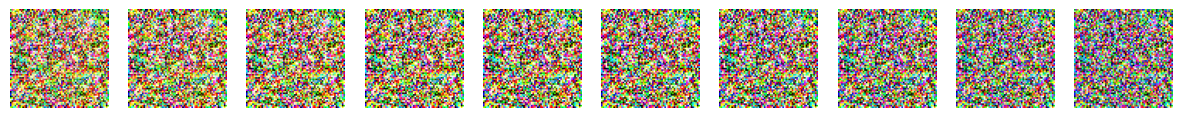

Epoch: 0 | Step 001 Loss: 0.67625
Epoch: 0 | Step 002 Loss: 0.64865
Epoch: 0 | Step 003 Loss: 0.60649
Epoch: 0 | Step 004 Loss: 0.57723
Epoch: 0 | Step 005 Loss: 0.53887
Epoch: 0 | Step 006 Loss: 0.52425
Epoch: 0 | Step 007 Loss: 0.49566
Epoch: 0 | Step 008 Loss: 0.46841
Epoch: 0 | Step 009 Loss: 0.44090
Epoch: 0 | Step 010 Loss: 0.41486
Epoch: 0 | Step 011 Loss: 0.42535
Epoch: 0 | Step 012 Loss: 0.42770
Epoch: 0 | Step 013 Loss: 0.40410
Epoch: 0 | Step 014 Loss: 0.40412
Epoch: 0 | Step 015 Loss: 0.38753
Epoch: 0 | Step 016 Loss: 0.38397
Epoch: 0 | Step 017 Loss: 0.36141
Epoch: 0 | Step 018 Loss: 0.36238
Epoch: 0 | Step 019 Loss: 0.36039
Epoch: 0 | Step 020 Loss: 0.35166
Epoch: 0 | Step 021 Loss: 0.35404
Epoch: 0 | Step 022 Loss: 0.33726
Epoch: 0 | Step 023 Loss: 0.33528
Epoch: 0 | Step 024 Loss: 0.34180
Epoch: 0 | Step 025 Loss: 0.31625


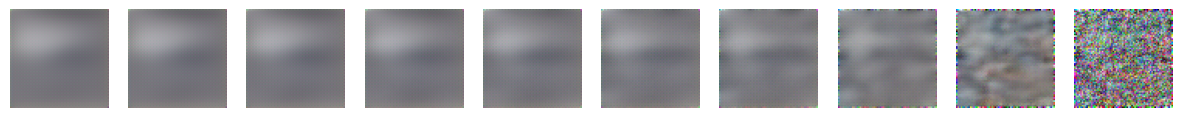

Epoch: 0 | Step 026 Loss: 0.31829
Epoch: 0 | Step 027 Loss: 0.31834
Epoch: 0 | Step 028 Loss: 0.31457
Epoch: 0 | Step 029 Loss: 0.29714
Epoch: 0 | Step 030 Loss: 0.30568
Epoch: 0 | Step 031 Loss: 0.31015
Epoch: 0 | Step 032 Loss: 0.30844
Epoch: 0 | Step 033 Loss: 0.29288
Epoch: 0 | Step 034 Loss: 0.29423
Epoch: 0 | Step 035 Loss: 0.30557
Epoch: 0 | Step 036 Loss: 0.28690
Epoch: 0 | Step 037 Loss: 0.29645
Epoch: 0 | Step 038 Loss: 0.29982
Epoch: 0 | Step 039 Loss: 0.28763
Epoch: 0 | Step 040 Loss: 0.28063
Epoch: 0 | Step 041 Loss: 0.25554
Epoch: 0 | Step 042 Loss: 0.29967
Epoch: 0 | Step 043 Loss: 0.29040
Epoch: 0 | Step 044 Loss: 0.26330
Epoch: 0 | Step 045 Loss: 0.28534
Epoch: 0 | Step 046 Loss: 0.25983
Epoch: 0 | Step 047 Loss: 0.27793
Epoch: 0 | Step 048 Loss: 0.25805
Epoch: 0 | Step 049 Loss: 0.25808
Epoch: 0 | Step 050 Loss: 0.23963


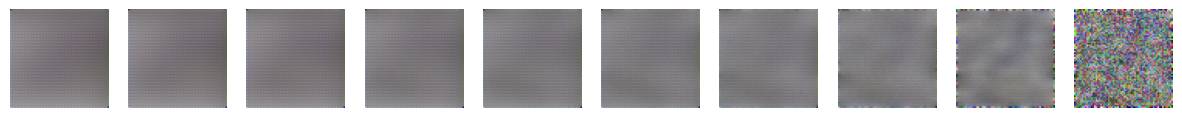

Epoch: 0 | Step 051 Loss: 0.27322
Epoch: 0 | Step 052 Loss: 0.23704
Epoch: 0 | Step 053 Loss: 0.23871
Epoch: 0 | Step 054 Loss: 0.24814
Epoch: 0 | Step 055 Loss: 0.25814
Epoch: 0 | Step 056 Loss: 0.23862
Epoch: 0 | Step 057 Loss: 0.27835
Epoch: 0 | Step 058 Loss: 0.29643
Epoch: 0 | Step 059 Loss: 0.28234
Epoch: 0 | Step 060 Loss: 0.30682
Epoch: 0 | Step 061 Loss: 0.36827
Epoch: 0 | Step 062 Loss: 0.38353
Epoch: 0 | Step 063 Loss: 0.33706
Epoch: 0 | Step 064 Loss: 0.31559
Epoch: 0 | Step 065 Loss: 0.34019
Epoch: 0 | Step 066 Loss: 0.29806
Epoch: 0 | Step 067 Loss: 0.28838
Epoch: 0 | Step 068 Loss: 0.26348
Epoch: 0 | Step 069 Loss: 0.27284
Epoch: 0 | Step 070 Loss: 0.29865
Epoch: 0 | Step 071 Loss: 0.30118
Epoch: 0 | Step 072 Loss: 0.28045
Epoch: 0 | Step 073 Loss: 0.29135
Epoch: 0 | Step 074 Loss: 0.27965
Epoch: 0 | Step 075 Loss: 0.26411


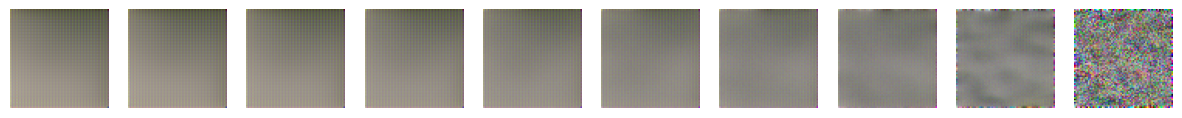

Epoch: 0 | Step 076 Loss: 0.28059
Epoch: 0 | Step 077 Loss: 0.27429
Epoch: 0 | Step 078 Loss: 0.26199
Epoch: 0 | Step 079 Loss: 0.27498
Epoch: 0 | Step 080 Loss: 0.26745
Epoch: 0 | Step 081 Loss: 0.25721
Epoch: 0 | Step 082 Loss: 0.26554
Epoch: 0 | Step 083 Loss: 0.24374
Epoch: 0 | Step 084 Loss: 0.23656
Epoch: 0 | Step 085 Loss: 0.25349
Epoch: 0 | Step 086 Loss: 0.26245
Epoch: 0 | Step 087 Loss: 0.26588
Epoch: 0 | Step 088 Loss: 0.23882
Epoch: 0 | Step 089 Loss: 0.22014
Epoch: 0 | Step 090 Loss: 0.26142
Epoch: 0 | Step 091 Loss: 0.23134
Epoch: 0 | Step 092 Loss: 0.24940
Epoch: 0 | Step 093 Loss: 0.23933
Epoch: 0 | Step 094 Loss: 0.24980
Epoch: 0 | Step 095 Loss: 0.23518
Epoch: 0 | Step 096 Loss: 0.21913
Epoch: 0 | Step 097 Loss: 0.24392
Epoch: 0 | Step 098 Loss: 0.24174
Epoch: 0 | Step 099 Loss: 0.22544
Epoch: 0 | Step 100 Loss: 0.22936


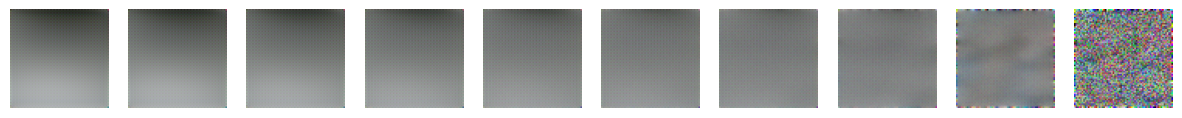

Epoch: 0 | Step 101 Loss: 0.24773
Epoch: 0 | Step 102 Loss: 0.22490
Epoch: 0 | Step 103 Loss: 0.25136
Epoch: 0 | Step 104 Loss: 0.26632
Epoch: 0 | Step 105 Loss: 0.22381
Epoch: 0 | Step 106 Loss: 0.25267
Epoch: 0 | Step 107 Loss: 0.22223
Epoch: 0 | Step 108 Loss: 0.24457
Epoch: 0 | Step 109 Loss: 0.24550
Epoch: 0 | Step 110 Loss: 0.21505
Epoch: 0 | Step 111 Loss: 0.23211
Epoch: 0 | Step 112 Loss: 0.24371
Epoch: 0 | Step 113 Loss: 0.23767
Epoch: 0 | Step 114 Loss: 0.22606
Epoch: 0 | Step 115 Loss: 0.23377
Epoch: 0 | Step 116 Loss: 0.22919
Epoch: 0 | Step 117 Loss: 0.21805
Epoch: 0 | Step 118 Loss: 0.22422
Epoch: 0 | Step 119 Loss: 0.23346
Epoch: 0 | Step 120 Loss: 0.21387
Epoch: 0 | Step 121 Loss: 0.25465
Epoch: 0 | Step 122 Loss: 0.21781
Epoch: 0 | Step 123 Loss: 0.21669
Epoch: 0 | Step 124 Loss: 0.21764
Epoch: 0 | Step 125 Loss: 0.22860


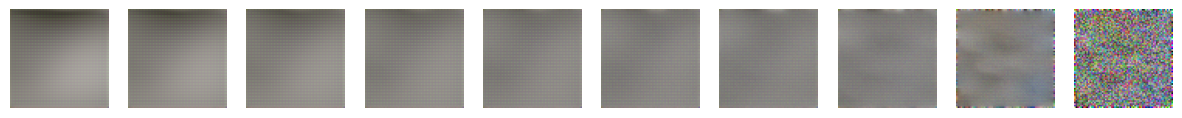

Epoch: 1 | Step 000 Loss: 0.22812


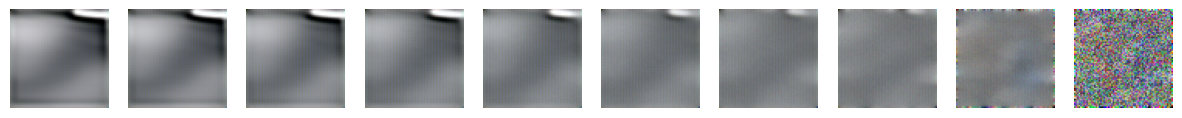

Epoch: 1 | Step 001 Loss: 0.21749
Epoch: 1 | Step 002 Loss: 0.23387
Epoch: 1 | Step 003 Loss: 0.21626
Epoch: 1 | Step 004 Loss: 0.21667
Epoch: 1 | Step 005 Loss: 0.23083
Epoch: 1 | Step 006 Loss: 0.23660
Epoch: 1 | Step 007 Loss: 0.23456
Epoch: 1 | Step 008 Loss: 0.21926
Epoch: 1 | Step 009 Loss: 0.22146
Epoch: 1 | Step 010 Loss: 0.21682
Epoch: 1 | Step 011 Loss: 0.22446
Epoch: 1 | Step 012 Loss: 0.20401
Epoch: 1 | Step 013 Loss: 0.21680
Epoch: 1 | Step 014 Loss: 0.22078
Epoch: 1 | Step 015 Loss: 0.21990
Epoch: 1 | Step 016 Loss: 0.19964
Epoch: 1 | Step 017 Loss: 0.21952
Epoch: 1 | Step 018 Loss: 0.21889
Epoch: 1 | Step 019 Loss: 0.20765
Epoch: 1 | Step 020 Loss: 0.22152
Epoch: 1 | Step 021 Loss: 0.21032
Epoch: 1 | Step 022 Loss: 0.22627
Epoch: 1 | Step 023 Loss: 0.20617
Epoch: 1 | Step 024 Loss: 0.20943
Epoch: 1 | Step 025 Loss: 0.21114


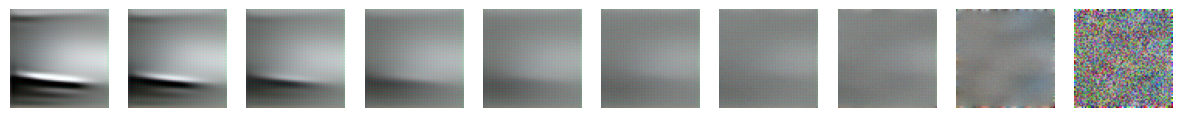

Epoch: 1 | Step 026 Loss: 0.21297
Epoch: 1 | Step 027 Loss: 0.23278
Epoch: 1 | Step 028 Loss: 0.19163
Epoch: 1 | Step 029 Loss: 0.21588
Epoch: 1 | Step 030 Loss: 0.19790
Epoch: 1 | Step 031 Loss: 0.23029
Epoch: 1 | Step 032 Loss: 0.21927
Epoch: 1 | Step 033 Loss: 0.21818
Epoch: 1 | Step 034 Loss: 0.22686
Epoch: 1 | Step 035 Loss: 0.21395
Epoch: 1 | Step 036 Loss: 0.19715
Epoch: 1 | Step 037 Loss: 0.20889
Epoch: 1 | Step 038 Loss: 0.22507
Epoch: 1 | Step 039 Loss: 0.20948
Epoch: 1 | Step 040 Loss: 0.23849
Epoch: 1 | Step 041 Loss: 0.21730
Epoch: 1 | Step 042 Loss: 0.21354
Epoch: 1 | Step 043 Loss: 0.22091
Epoch: 1 | Step 044 Loss: 0.20392
Epoch: 1 | Step 045 Loss: 0.19642
Epoch: 1 | Step 046 Loss: 0.20746
Epoch: 1 | Step 047 Loss: 0.19335
Epoch: 1 | Step 048 Loss: 0.21874
Epoch: 1 | Step 049 Loss: 0.22087
Epoch: 1 | Step 050 Loss: 0.20718


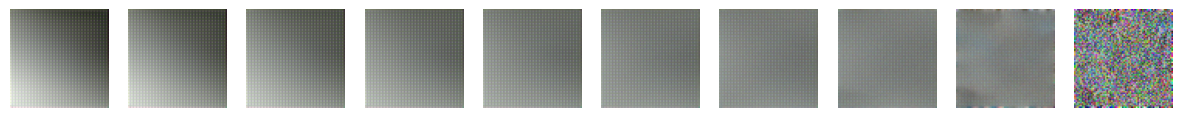

Epoch: 1 | Step 051 Loss: 0.19864
Epoch: 1 | Step 052 Loss: 0.20597
Epoch: 1 | Step 053 Loss: 0.22551
Epoch: 1 | Step 054 Loss: 0.20070
Epoch: 1 | Step 055 Loss: 0.20286
Epoch: 1 | Step 056 Loss: 0.19204
Epoch: 1 | Step 057 Loss: 0.20120
Epoch: 1 | Step 058 Loss: 0.22636
Epoch: 1 | Step 059 Loss: 0.19460
Epoch: 1 | Step 060 Loss: 0.20357
Epoch: 1 | Step 061 Loss: 0.19375
Epoch: 1 | Step 062 Loss: 0.20543
Epoch: 1 | Step 063 Loss: 0.20129
Epoch: 1 | Step 064 Loss: 0.20624
Epoch: 1 | Step 065 Loss: 0.19424
Epoch: 1 | Step 066 Loss: 0.22058
Epoch: 1 | Step 067 Loss: 0.21358
Epoch: 1 | Step 068 Loss: 0.20964
Epoch: 1 | Step 069 Loss: 0.19406
Epoch: 1 | Step 070 Loss: 0.21122
Epoch: 1 | Step 071 Loss: 0.21813
Epoch: 1 | Step 072 Loss: 0.19804
Epoch: 1 | Step 073 Loss: 0.21760
Epoch: 1 | Step 074 Loss: 0.20139
Epoch: 1 | Step 075 Loss: 0.20093


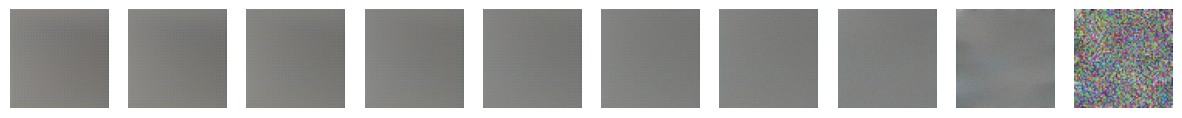

Epoch: 1 | Step 076 Loss: 0.19802
Epoch: 1 | Step 077 Loss: 0.20193
Epoch: 1 | Step 078 Loss: 0.20312
Epoch: 1 | Step 079 Loss: 0.19561
Epoch: 1 | Step 080 Loss: 0.18670
Epoch: 1 | Step 081 Loss: 0.21081
Epoch: 1 | Step 082 Loss: 0.18270
Epoch: 1 | Step 083 Loss: 0.18942
Epoch: 1 | Step 084 Loss: 0.19660
Epoch: 1 | Step 085 Loss: 0.18681
Epoch: 1 | Step 086 Loss: 0.20409
Epoch: 1 | Step 087 Loss: 0.17619
Epoch: 1 | Step 088 Loss: 0.19799
Epoch: 1 | Step 089 Loss: 0.20949
Epoch: 1 | Step 090 Loss: 0.19418
Epoch: 1 | Step 091 Loss: 0.19046
Epoch: 1 | Step 092 Loss: 0.18690
Epoch: 1 | Step 093 Loss: 0.19234
Epoch: 1 | Step 094 Loss: 0.19743
Epoch: 1 | Step 095 Loss: 0.20375
Epoch: 1 | Step 096 Loss: 0.19049
Epoch: 1 | Step 097 Loss: 0.18866
Epoch: 1 | Step 098 Loss: 0.17386
Epoch: 1 | Step 099 Loss: 0.20131
Epoch: 1 | Step 100 Loss: 0.18324


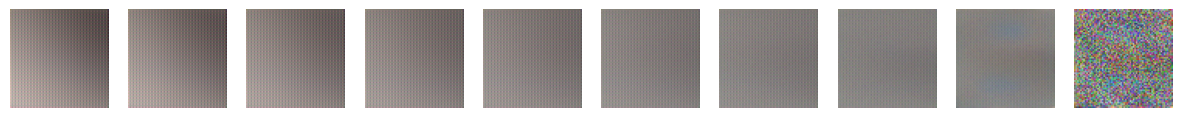

Epoch: 1 | Step 101 Loss: 0.19535
Epoch: 1 | Step 102 Loss: 0.20417
Epoch: 1 | Step 103 Loss: 0.19278
Epoch: 1 | Step 104 Loss: 0.19470
Epoch: 1 | Step 105 Loss: 0.19380
Epoch: 1 | Step 106 Loss: 0.19433
Epoch: 1 | Step 107 Loss: 0.19078
Epoch: 1 | Step 108 Loss: 0.18638
Epoch: 1 | Step 109 Loss: 0.18499
Epoch: 1 | Step 110 Loss: 0.17772
Epoch: 1 | Step 111 Loss: 0.18910
Epoch: 1 | Step 112 Loss: 0.20757
Epoch: 1 | Step 113 Loss: 0.19873
Epoch: 1 | Step 114 Loss: 0.16600
Epoch: 1 | Step 115 Loss: 0.20862
Epoch: 1 | Step 116 Loss: 0.18188
Epoch: 1 | Step 117 Loss: 0.18139
Epoch: 1 | Step 118 Loss: 0.18388
Epoch: 1 | Step 119 Loss: 0.18473
Epoch: 1 | Step 120 Loss: 0.17665
Epoch: 1 | Step 121 Loss: 0.17861
Epoch: 1 | Step 122 Loss: 0.17429
Epoch: 1 | Step 123 Loss: 0.17455
Epoch: 1 | Step 124 Loss: 0.17133
Epoch: 1 | Step 125 Loss: 0.20060


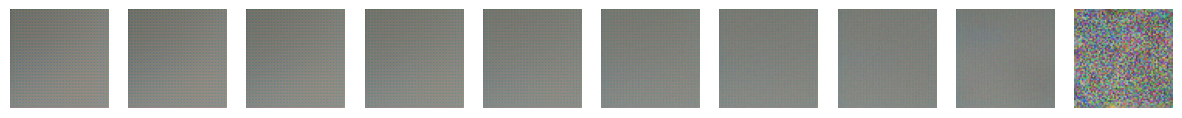

In [35]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 2

for epoch in range(epochs):
    for step, batch in enumerate(dl):
        optimizer.zero_grad()

        t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
        loss = get_loss(model, batch[0], t)
        loss.backward()
        optimizer.step()

        print(f"Epoch: {epoch} | Step {step:03d} Loss: {loss.item():.5f}")
        if step% 25 == 0:
          sample_image()


# References
-  [DeepFindr](https://youtu.be/a4Yfz2FxXiY?si=q82_lUXeLf6ElkLa)